In [116]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
from torchsummary import summary

In [82]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
training_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [83]:
training_dataset, validation_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ), Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

In [84]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=True)

In [85]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
    image = image.clip(0, 1)
    return image

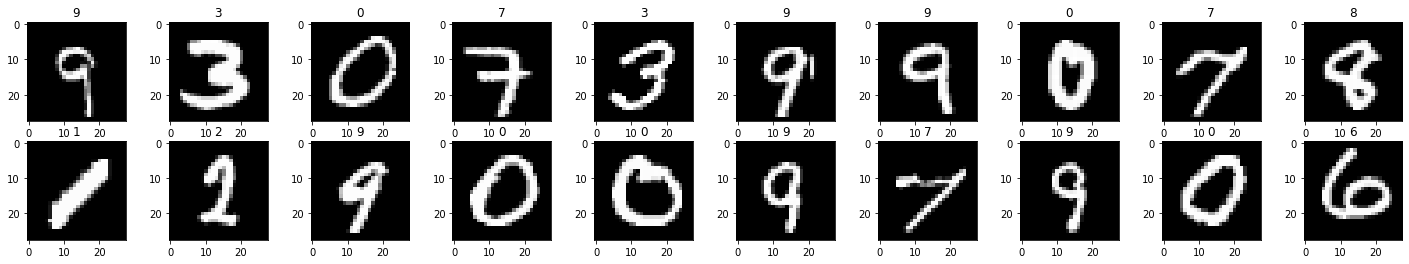

In [86]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1)
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

In [102]:
class Model(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        nn.init.kaiming_uniform(self.linear1.weight)
        self.linear2 = nn.Linear(H1, H2)
        nn.init.kaiming_uniform(self.linear2.weight)
        self.linear3 = nn.Linear(H2, D_out)
        nn.init.kaiming_uniform(self.linear3.weight)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)
    

In [103]:
model = Model(784, 125, 65, 10)

/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  """
/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  import sys
/Users/kirillvladimirov/PycharmProjects/cv_projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  if __name__ == '__main__':


In [104]:
model

Model(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [105]:
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [106]:
%%time

epochs = 20
train_loss_history = []
train_correct_history = []
valid_loss_history = []
valid_correct_history = []

for i in range(epochs):
    current_train_loss = 0.0
    current_train_correct = 0.0
    current_valid_loss = 0.0
    current_valid_correct = 0.0
    
    for images, labels in training_loader:
        images = images.view(images.shape[0], -1)
        y_hat = model(images)
        loss = criterian(y_hat, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(y_hat, 1)
        current_train_loss += loss.item()
        current_train_correct += torch.sum(preds == labels.data)
    else:
        print(f"epoch: {i}:")
        with torch.no_grad():
            for val_images, val_labels in validation_loader:
                val_images = val_images.view(images.shape[0], -1)
                y_val = model(val_images)
                val_loss = criterian(y_val, val_labels)
                
                _, preds = torch.max(y_val, 1)
                current_valid_loss += val_loss.item()
                current_valid_correct += torch.sum(preds == val_labels.data)
        
        epoch_loss = current_train_loss/len(training_loader.dataset)
        epoch_acc = current_train_correct.float()/len(training_loader)
        train_loss_history.append(epoch_loss)
        train_correct_history.append(epoch_acc)
        print(f"training loss: {epoch_loss}, training accuracy: {epoch_acc}")
        epoch_loss = current_valid_loss/len(validation_loader.dataset)
        epoch_acc = current_valid_correct.float()/len(validation_loader)
        valid_loss_history.append(epoch_loss)
        valid_correct_history.append(epoch_acc)
        print(f"validation loss: {epoch_loss}, validation accuracy: {epoch_acc}")

epoch: 0:
training loss: 0.004809431074559689, training accuracy: 86.2750015258789
validation loss: 0.0023391617640852926, validation accuracy: 92.75
epoch: 1:
training loss: 0.0024101137104133763, training accuracy: 92.7683334350586
validation loss: 0.002115806778520346, validation accuracy: 93.91000366210938
epoch: 2:
training loss: 0.002212853837075333, training accuracy: 93.41500091552734
validation loss: 0.0020957384986802934, validation accuracy: 93.69000244140625
epoch: 3:
training loss: 0.001987308822913716, training accuracy: 94.163330078125
validation loss: 0.002342448081821203, validation accuracy: 93.26000213623047
epoch: 4:
training loss: 0.0018804975852525483, training accuracy: 94.38166809082031
validation loss: 0.0019867717012763022, validation accuracy: 94.08000183105469
epoch: 5:
training loss: 0.0018182579872508843, training accuracy: 94.73332977294922
validation loss: 0.001846825160831213, validation accuracy: 94.80000305175781
epoch: 6:
training loss: 0.00174255542

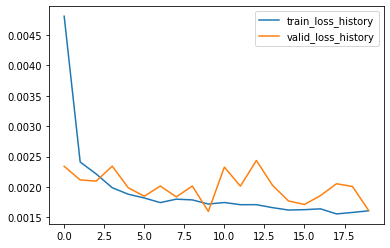

In [107]:
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(valid_loss_history, label="valid_loss_history")
plt.legend()

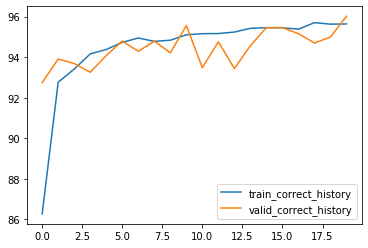

In [108]:
plt.plot(train_correct_history, label="train_correct_history")
plt.plot(valid_correct_history, label="valid_correct_history")
plt.legend()

In [115]:
summary(model, (784, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 125]          98,125
            Linear-2                   [-1, 65]           8,190
            Linear-3                   [-1, 10]             660
Total params: 106,975
Trainable params: 106,975
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41
----------------------------------------------------------------
